In [ ]:
import sys
import os
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from itertools import combinations
from typing import List, Tuple, Dict, Any

In [ ]:
# CLASSE DE BASE ENVIRONNEMENT

from abc import ABC, abstractmethod

class BaseEnvironment(ABC):
    
    @abstractmethod
    def reset(self):
        pass
    
    @abstractmethod
    def step(self, action, is_dynamic_programming=False):
        pass
    
    @property
    @abstractmethod
    def _build_transition_matrix(self):
        pass
    
    @property
    @abstractmethod
    def _build_reward_matrix(self):
        pass


In [ ]:
# UTILITAIRES POUR SAUVEGARDE
def save_model(data: Dict[str, Any], filepath: str, format: str = 'pickle') -> None:
    """Sauvegarde un modèle dans le format spécifié."""
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    
    if format == 'pickle':
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)
    elif format == 'joblib':
        if not JOBLIB_AVAILABLE:
            raise ImportError("joblib n'est pas disponible.")
        joblib.dump(data, filepath)
    else:
        raise ValueError(f"Format '{format}' non supporté.")

def load_model(filepath: str, format: str = 'auto') -> Dict[str, Any]:
    """Charge un modèle depuis le format spécifié."""
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Le fichier {filepath} n'existe pas.")
    
    if format == 'auto':
        extension = os.path.splitext(filepath)[1].lower()
        format = 'pickle' if extension == '.pkl' else 'joblib'
    
    if format == 'pickle':
        with open(filepath, 'rb') as f:
            return pickle.load(f)
    elif format == 'joblib':
        if not JOBLIB_AVAILABLE:
            raise ImportError("joblib n'est pas disponible.")
        return joblib.load(filepath)
    else:
        raise ValueError(f"Format '{format}' non supporté.")


In [ ]:
class MonteCarloES:
    """
    Implémentation de Monte Carlo Exploring Starts.
    
    MC-ES assure que tous les couples état-action ont une probabilité
    non nulle d'être sélectionnés comme point de départ.
    """
    
    def __init__(self, env: Any, gamma: float = 1.0):
        """
        Initialise Monte Carlo ES.
        
        Args:
            env: Environnement
            gamma: Facteur de discount
        """
        self.env = env
        self.gamma = gamma
        self.Q = None
        self.policy = None
        self.returns_sum = {}
        self.returns_count = {}
        self.history = []
        
        # Initialiser les structures MDP
        self._initialize_mdp_structures()
        
    def _initialize_mdp_structures(self):
        """Initialise les structures MDP nécessaires."""
        # Priorité 1: Environnements avec get_mdp_info (nos environnements personnalisés)
        if hasattr(self.env, 'get_mdp_info'):
            mdp_info = self.env.get_mdp_info()
            self.nS = len(mdp_info['states'])
            self.nA = len(mdp_info['actions'])
            self.transition_probs = mdp_info['transition_matrix']
            self.rewards = mdp_info['reward_matrix']
            self.terminal_states = mdp_info.get('terminals', [])
            
        # Priorité 2: Environnements Gym avec attribut P
        elif hasattr(self.env, 'P'):
            # Déterminer le nombre d'états et d'actions
            if hasattr(self.env, 'nS') and hasattr(self.env, 'nA'):
                self.nS = self.env.nS
                self.nA = self.env.nA
            else:
                # Environnement générique
                self.nS = getattr(self.env, 'observation_space', type('obj', (object,), {'n': 16})).n
                self.nA = getattr(self.env, 'action_space', type('obj', (object,), {'n': 4})).n
            
            # Extraire les probabilités de transition
            self.transition_probs = self._extract_transition_probabilities()
            self.rewards = self._extract_rewards()
            
            # Identifier les états terminaux
            self.terminal_states = []
            if hasattr(self.env, 'desc'):
                # Pour FrozenLake par exemple
                desc = self.env.desc
                for i in range(desc.shape[0]):
                    for j in range(desc.shape[1]):
                        if desc[i, j] in [b'H', b'G']:  # Hole ou Goal
                            self.terminal_states.append(i * desc.shape[1] + j)
        
        # Priorité 3: Environnements sans MDP explicite
        else:
            # Déterminer le nombre d'états et d'actions
            if hasattr(self.env, 'nS') and hasattr(self.env, 'nA'):
                self.nS = self.env.nS
                self.nA = self.env.nA
            else:
                # Environnement générique
                self.nS = getattr(self.env, 'observation_space', type('obj', (object,), {'n': 16})).n
                self.nA = getattr(self.env, 'action_space', type('obj', (object,), {'n': 4})).n
            
            self.transition_probs = None
            self.rewards = [0.0, 1.0]  # Récompenses par défaut
            self.terminal_states = []
        
        # Initialiser Q et politique
        self.Q = np.zeros((self.nS, self.nA), dtype=float)
        self.policy = np.zeros(self.nS, dtype=int)
        
    def _extract_transition_probabilities(self):
        """Extrait les probabilités de transition de l'environnement."""
        rewards = set()
        for s in range(self.nS):
            for a in range(self.nA):
                if s in self.env.P and a in self.env.P[s]:
                    for prob, next_state, reward, done in self.env.P[s][a]:
                        rewards.add(reward)
        
        self.rewards = sorted(list(rewards))
        p = np.zeros((self.nS, self.nA, self.nS, len(self.rewards)))
        
        for s in range(self.nS):
            for a in range(self.nA):
                if s in self.env.P and a in self.env.P[s]:
                    for prob, next_state, reward, done in self.env.P[s][a]:
                        r_idx = self.rewards.index(reward)
                        p[s, a, next_state, r_idx] = prob
        
        return p
        
    def _extract_rewards(self):
        """Extrait la liste des récompenses possibles."""
        rewards = set()
        for s in range(self.nS):
            for a in range(self.nA):
                if s in self.env.P and a in self.env.P[s]:
                    for prob, next_state, reward, done in self.env.P[s][a]:
                        rewards.add(reward)
        return sorted(list(rewards))
    
    def sample_next_state_reward(self, s: int, a: int) -> Tuple[int, float]:
        """
        Échantillonne l'état suivant s' et la récompense r à partir des probabilités de transition.
        
        Args:
            s: État actuel
            a: Action
            
        Returns:
            Tuple (next_state, reward)
        """
        if self.transition_probs is None:
            # Fallback pour environnements sans probabilités explicites
            state = self.env.reset()
            next_state, reward, done, _ = self.env.step(a)
            return next_state, reward
        
        # Utiliser les probabilités de transition
        num_states = self.transition_probs.shape[2]
        
        # Construire une liste de (s', reward) avec prob > 0
        candidates = []
        probs = []
        
        for s_p in range(num_states):
            prob = self.transition_probs[s, a, s_p]
            if prob > 0:
                # Pour les environnements avec get_mdp_info, la récompense est dans reward_matrix
                if hasattr(self.env, 'get_mdp_info'):
                    reward = self.rewards[s, a]  # reward_matrix[s, a]
                else:
                    # Pour les environnements Gym, utiliser la récompense associée à la transition
                    reward = self.rewards[0]  # Fallback
                
                candidates.append((s_p, reward))
                probs.append(prob)
        
        # Normaliser (au cas où)
        probs = np.array(probs, dtype=np.float64)
        if probs.sum() > 0:
            probs /= probs.sum()
        else:
            # Cas d'erreur, distribution uniforme
            probs = np.ones(len(candidates)) / len(candidates) if candidates else np.array([1.0])
            
        # Tirage
        if candidates:
            idx = np.random.choice(len(candidates), p=probs)
            s_p, reward = candidates[idx]
            return s_p, reward
        else:
            return s, 0.0
        
    def generate_episode(self, exploring_starts: bool = True) -> List[Tuple[int, int, float]]:
        """
        Génère un épisode complet avec Exploring Starts.
        
        Args:
            exploring_starts: Si True, utilise exploring starts
            
        Returns:
            Liste des transitions (état, action, reward)
        """
        episode = []
        
        if exploring_starts:
            # Exploring Start: état et action initiaux aléatoires
            start_state = random.choice(list(range(self.nS)))
            start_action = random.choice(list(range(self.nA)))
            
            # Appliquer la transition (s,a) fixée par ES
            s_next, r = self.sample_next_state_reward(start_state, start_action)
            episode.append((start_state, start_action, r))
            s = s_next
        else:
            # Démarrage normal
            s = random.choice(list(range(self.nS)))
        
        # Continuer selon la politique jusqu'à l'état terminal
        max_steps = 1000  # Protection contre les boucles infinies
        steps = 0
        
        while s not in self.terminal_states and steps < max_steps:
            a = self.policy[s]
            s_next, r = self.sample_next_state_reward(s, a)
            episode.append((s, a, r))
            s = s_next
            steps += 1
            
            if s in self.terminal_states:
                break
        
        return episode
        
    def update_q_values(self, episode: List[Tuple[int, int, float]]):
        """
        Met à jour les valeurs Q à partir d'un épisode (First-Visit).
        
        Args:
            episode: Liste des transitions (état, action, reward)
        """
        # Calculer les returns
        G = 0.0
        for t in range(len(episode) - 1, -1, -1):
            s_t, a_t, r_tp1 = episode[t]
            G = self.gamma * G + r_tp1
            
            # Vérifier si c'est la première visite de (s_t, a_t)
            first_visit = True
            for j in range(t):
                if episode[j][0] == s_t and episode[j][1] == a_t:
                    first_visit = False
                    break
            
            if first_visit:
                # Mettre à jour Q(s,a) avec la moyenne des returns
                key = (s_t, a_t)
                self.returns_sum[key] = self.returns_sum.get(key, 0.0) + G
                self.returns_count[key] = self.returns_count.get(key, 0) + 1
                self.Q[s_t, a_t] = self.returns_sum[key] / self.returns_count[key]
        
    def improve_policy(self):
        """Met à jour la politique basée sur les valeurs Q (greedy)."""
        for s in range(self.nS):
            if s not in self.terminal_states:
                self.policy[s] = int(np.argmax(self.Q[s, :]))
        
    def train(self, num_episodes: int = 1000) -> Dict[str, Any]:
        """
        Entraîne l'algorithme MC-ES.
        
        Args:
            num_episodes: Nombre d'épisodes d'entraînement
            
        Returns:
            Dictionnaire contenant les résultats d'entraînement
        """
        self.history = []
        
        for ep in range(1, num_episodes + 1):
            # Générer un épisode
            episode = self.generate_episode(exploring_starts=True)
            
            # Mettre à jour les valeurs Q
            self.update_q_values(episode)
            
            # Améliorer la politique
            self.improve_policy()
            
            # Enregistrer les statistiques
            if ep % max(1, num_episodes // 20) == 0 or ep == 1:
                avg_q = np.mean(self.Q)
                max_q = np.max(self.Q)
                episode_length = len(episode)
                
                self.history.append({
                    'episode': ep,
                    'avg_q_value': avg_q,
                    'max_q_value': max_q,
                    'episode_length': episode_length,
                    'num_state_actions_visited': len(self.returns_count)
                })
                
                print(f"Épisode {ep}/{num_episodes} - Q moyen: {avg_q:.4f}, Longueur: {episode_length}")
        
        return {
            'Q': self.Q,
            'policy': self.policy,
            'history': self.history,
            'episodes': num_episodes,
            'returns_sum': self.returns_sum,
            'returns_count': self.returns_count
        }
        
    def save(self, filepath: str):
        """Sauvegarde le modèle."""
        model_data = {
            'Q': self.Q,
            'policy': self.policy,
            'gamma': self.gamma,
            'history': self.history,
            'returns_sum': self.returns_sum,
            'returns_count': self.returns_count
        }
        save_model(model_data, filepath)
        
    def load(self, filepath: str):
        """Charge un modèle sauvegardé."""
        model_data = load_model(filepath)
        self.Q = model_data['Q']
        self.policy = model_data['policy']
        self.gamma = model_data['gamma']
        self.history = model_data['history']
        self.returns_sum = model_data['returns_sum']
        self.returns_count = model_data['returns_count']



In [ ]:
# ENVIRONNEMENT LINE WORLD

class LineWorld(BaseEnvironment):
    def __init__(self, length=8):
        self.length = length
        self.start = length // 2
        self.terminals = [0, length-1]
        self.actions = [0, 1]
        self.reset()

        # Matrice de transition et récompenses pour les algorithmes de programmation dynamique
        self._transition_matrix = self._build_transition_matrix()
        self._reward_matrix = self._build_reward_matrix()

        # Métriques
        self.episode_count = 0
        self.steps_count = 0
        self.total_reward = 0
        self.visited_states = set()
        self.episode_history = []

    def reset(self):
        # Réinitialisation de l'environnement
        self.state = self.start
        return self.state

    def step(self, action, is_dynamic_programming=False):
        current_state = self.state
    
        # Calcul du prochain état
        if action == 0:  # Gauche
            reward = -1.0
            next_state = max(0, self.state - 1)
        else:  # Droite
            reward = 1.0
            next_state = min(self.length-1, self.state + 1)

        # Vérification du milieu APRÈS le calcul du next_state
        if next_state == self.length // 2:
            reward = 0.0

        done = next_state in self.terminals
        self.state = next_state

        if is_dynamic_programming:
            return {
                'state': self.state,
                'previous_state': current_state,
                'action': action
            }, reward, done
        else:
            return next_state, reward, done, {
                'action_name': 'gauche' if action == 0 else 'droite',
                'position': self.state,
                'previous_position': current_state
            }

    def visualisation(self):
        # Visualisation de notre environnement
        print("\n" + "="*40)
        line = ["[ ]"] * self.length
        line[self.state] = "[A]"  # Position de l'agent
        line[0] = "[T]"  # Terminal gauche
        line[-1] = "[T]"  # Terminal droit
        print(" ".join(line))
        
        # On affiche les indices pour mieux comprendre
        indices = [f"{i:^3}" for i in range(self.length)]
        print(" ".join(indices))
        print("="*40)

    def _build_transition_matrix(self):
        # Construit la matrice de transition P(s'|s,a).
        P = np.zeros((self.length, len(self.actions), self.length))
        
        for s in range(self.length):
            # Action gauche (0)
            next_s = max(0, s - 1)
            P[s, 0, next_s] = 1.0
            
            # Action droite (1)
            next_s = min(self.length-1, s+1)
            P[s, 1, next_s] = 1.0
            
        return P

    def _build_reward_matrix(self):
        # Construit la matrice de récompense R(s,a).
        R = np.zeros((self.length, len(self.actions)))
        
        for s in range(self.length):
            # Action gauche
            next_s_left = max(0, s-1)
            if next_s_left in self.terminals:
                R[s, 0] = 1.0

            # Action droite (1)
            next_s_right = min(self.length-1, s+1)
            if next_s_right in self.terminals:
                R[s, 1] = 1.0
                
        return R

    def get_mdp_info(self):
        # Retourne les informations du MDP
        return {
            'states': range(self.length),
            'actions': self.actions,
            'transition_matrix': self._transition_matrix,
            'reward_matrix': self._reward_matrix,
            'terminals': self.terminals,
            'gamma': 0.99  
        }

    def get_state_space(self):
        return range(self.length)

    def get_action_space(self):
        return self.actions

    @property
    def transition_matrix(self):
        return self._transition_matrix

    @property
    def reward_matrix(self):
        return self._reward_matrix


In [ ]:
class GridWorld(BaseEnvironment):
    def __init__(self, n_rows=5, n_cols=5):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_states = n_rows * n_cols

        # Métriques sup
        self.steps_count = 0
        self.total_reward = 0
        self.visited_states = set()
        
        # Définition des actions : 0: Gauche, 1: Droite, 2: Haut, 3: Bas
        self.actions = [0, 1, 2, 3]
        
        # Les états terminaux sont dans les coins supérieur gauche et inférieur droit de la grille
        self.terminals = [0, self.n_states - 1]
        
        # CORRECTION: Récompenses équilibrées pour favoriser l'atteinte des terminaux
        self.rewards = {
            'movement': -0.1,  # Déplacement normal (petit coût pour favoriser l'efficacité)
            'middle': -1.0,    # Vers le milieu (pénalité modérée)
            'no_move': -0.5,   # Pas de mouvement possible
            'terminal': 10.0   # AJOUT: Récompense positive importante pour atteindre un terminal
        }
        
        # Position initiale (centre de la grille)
        self.start_row = self.n_rows // 2
        self.start_col = self.n_cols // 2
        self.start_state = self._pos_to_state(self.start_row, self.start_col)
        
        # Spécifique à la programmation dynamique
        self._transition_matrix = self._build_transition_matrix()
        self._reward_matrix = self._build_reward_matrix()
        
        # Initialisation
        self.reset()

    def reset(self):
        # Réinitialisation de l'environnement
        self.current_state = self.start_state
        self.done = False
        return self.current_state

    def step(self, action, for_dp=False):
        # Cette méthode est utilisée pour exécuter une action et retourner le résultat
        current_row, current_col = self._state_to_pos(self.current_state)
        new_row, new_col = current_row, current_col
        
        # Calcul de la nouvelle position
        if action == 0 and current_col > 0:  # Gauche
            new_col -= 1
        elif action == 1 and current_col < self.n_cols - 1:  # Droite
            new_col += 1
        elif action == 2 and current_row > 0:  # Haut
            new_row -= 1
        elif action == 3 and current_row < self.n_rows - 1:  # Bas
            new_row += 1
            
        next_state = self._pos_to_state(new_row, new_col)
        
        # CORRECTION: Calcul de la récompense avec bonus terminal
        if next_state in self.terminals:
            reward = self.rewards['terminal']  # Grande récompense pour atteindre un terminal
        elif (new_row, new_col) == (current_row, current_col):
            reward = self.rewards['no_move']
        elif next_state == self.start_state:
            reward = self.rewards['middle']
        else:
            reward = self.rewards['movement']
            
        self.done = next_state in self.terminals
        self.current_state = next_state
        
        # Mise à jour des métriques
        self.steps_count += 1
        self.total_reward += reward
        self.visited_states.add(next_state)

        if for_dp:
            return {
                'state': self.current_state,
                'position': (new_row, new_col),
                'previous_position': (current_row, current_col)
            }, reward, self.done
        else:
            return next_state, reward, self.done, {
                'position': (new_row, new_col),
                'action_name': ['gauche', 'droite', 'haut', 'bas'][action]
            }

    def _pos_to_state(self, row, col):
        # Convertit une position (row, col) en numéro d'état
        return row * self.n_cols + col

    def _state_to_pos(self, state):
        # Convertit un numéro d'état en position (row, col)
        return divmod(state, self.n_cols)

    def _build_transition_matrix(self):
        # Construit la matrice de transition P(s'|s,a)
        P = np.zeros((self.n_states, len(self.actions), self.n_states))
        
        for s in range(self.n_states):
            if s in self.terminals:
                # CORRECTION: Les états terminaux restent terminaux
                P[s, :, s] = 1.0
                continue
                
            row, col = self._state_to_pos(s)
            
            for a in self.actions:
                new_row, new_col = row, col
                
                if a == 0 and col > 0:
                    new_col -= 1
                elif a == 1 and col < self.n_cols - 1:
                    new_col += 1
                elif a == 2 and row > 0:
                    new_row -= 1
                elif a == 3 and row < self.n_rows - 1:
                    new_row += 1
                    
                next_state = self._pos_to_state(new_row, new_col)
                P[s, a, next_state] = 1.0
                
        return P

    def _build_reward_matrix(self):
        # CORRECTION: Construit la matrice des récompenses avec bonus terminal
        R = np.zeros((self.n_states, len(self.actions)))
        
        for s in range(self.n_states):
            if s in self.terminals:
                # Les états terminaux n'ont pas de récompenses d'actions
                continue
                
            row, col = self._state_to_pos(s)
            
            for a in self.actions:
                new_row, new_col = row, col
                
                if a == 0 and col > 0:
                    new_col -= 1
                elif a == 1 and col < self.n_cols - 1:
                    new_col += 1
                elif a == 2 and row > 0:
                    new_row -= 1
                elif a == 3 and row < self.n_rows - 1:
                    new_row += 1
                    
                next_state = self._pos_to_state(new_row, new_col)
                
                # CORRECTION: Récompense positive pour atteindre les terminaux
                if next_state in self.terminals:
                    R[s, a] = self.rewards['terminal']
                elif (new_row, new_col) == (row, col):
                    R[s, a] = self.rewards['no_move']
                elif next_state == self.start_state:
                    R[s, a] = self.rewards['middle']
                else:
                    R[s, a] = self.rewards['movement']
        
        return R

    def get_mdp_info(self):
        # Retourne les informations du MDP pour les algorithmes de Dynamic Programming
        return {
            'states': range(self.n_states),
            'actions': self.actions,
            'transition_matrix': self._transition_matrix,
            'reward_matrix': self._reward_matrix,
            'terminals': self.terminals,
            'gamma': 0.99
        }

    def visualisation(self):
        # Affiche l'état actuel de notre environnement
        print("\n" + "="*40)
        print("Grid World CORRIGÉ".center(40))
        print("-"*40)
        
        grid = [['[ ]' for _ in range(self.n_cols)] for _ in range(self.n_rows)]
        
        # Marquer les terminaux
        for terminal in self.terminals:
            term_row, term_col = self._state_to_pos(terminal)
            grid[term_row][term_col] = '[T]'
        
        # Position actuelle
        agent_row, agent_col = self._state_to_pos(self.current_state)
        grid[agent_row][agent_col] = '[A]'
        
        # Afficher la grille avec bordures
        print('+' + '---+'*self.n_cols)
        for grid_row in grid:
            print('|' + '|'.join(grid_row) + '|')
            print('+' + '---+'*self.n_cols)
        
        print(f"Position de l'agent : ({agent_row},{agent_col})")
        print("="*40)

    def get_state_space(self):
        return range(self.n_states)

    def get_action_space(self):
        return self.actions

    @property
    def transition_matrix(self):
        return self._transition_matrix

    @property
    def reward_matrix(self):
        return self._reward_matrix

In [ ]:
class RockPaperScissors:
    # États du jeu
    INITIAL_STATE = 0
    ROUND1_START = 1
    ROUND2_START = 4
    TERMINAL_DP = 7
    TERMINAL_MC = 8

    def __init__(self):
        self.actions = [0, 1, 2]
        self.n_actions = len(self.actions)
        self.n_states = 9

        # Matrice du jeu de base
        self.reward_matrix = np.array([
            [0, -1, 1],   # Pierre
            [1, 0, -1],   # Feuille
            [-1, 1, 0]    # Ciseaux
        ])

        self.agent_action_round1 = None
        self.transition_matrix = self._build_transition_matrix()
        self.reward_matrix_dp = self._build_reward_matrix()

        self.steps_count = 0
        self.total_reward = 0
        self.wins = 0
        self.total_games = 0
        self.reset()

    def reset(self):
        self.current_round = 0
        self.previous_agent_action = None
        self.previous_opponent_action = None
        self.agent_action_round1 = None
        self.done = False
        self.steps_count = 0
        self.total_reward = 0
        return self._get_state()

    def step(self, action, is_dynamic_programming=False):
        if self.current_round == 0:
            opponent_action = random.choice(self.actions)
            self.agent_action_round1 = action
        else:
            opponent_action = self.agent_action_round1
            
        reward = self.reward_matrix[action, opponent_action]
        
        self.previous_agent_action = action
        self.previous_opponent_action = opponent_action
        self.current_round += 1
        self.done = self.current_round >= 2
        
        self.steps_count += 1
        self.total_reward += reward
        if reward > 0:
            self.wins += 1
        if self.done:
            self.total_games += 1

        if is_dynamic_programming:
            return self._get_state(for_dp=True), reward, self.done
        else:
            return self._get_state(for_dp=False), reward, self.done, {
                'round': self.current_round,
                'agent_action': action,
                'opponent_action': opponent_action
            }

    def _get_state(self, for_dp=False):
        if for_dp:
            if self.current_round == 0:
                return self.INITIAL_STATE
            elif self.current_round == 1:
                return self.ROUND1_START + self.previous_opponent_action
            elif self.current_round == 2 and not self.done:
                return self.ROUND2_START + self.agent_action_round1
            else:
                return self.TERMINAL_DP
        else:
            if self.current_round == 0:
                return self.INITIAL_STATE
            elif self.current_round == 1:
                return self.ROUND1_START + self.previous_opponent_action
            elif self.current_round == 2 and not self.done:
                return self.ROUND2_START + self.agent_action_round1
            else:
                return self.TERMINAL_MC

    def _build_transition_matrix(self):
        P = np.zeros((self.n_states, self.n_actions, self.n_states))
        
        # Depuis l'état initial (0)
        for action in self.actions:
            for opp_action in self.actions:
                next_state = self.ROUND1_START + opp_action
                P[self.INITIAL_STATE, action, next_state] = 1/3
        
        # Depuis les états après premier round (1-3)
        for state in range(self.ROUND1_START, self.ROUND2_START):
            for action in self.actions:
                next_state = self.ROUND2_START + action
                P[state, action, next_state] = 1.0
        
        # Depuis les états du second round (4-6)
        for state in range(self.ROUND2_START, self.TERMINAL_DP):
            for action in self.actions:
                P[state, action, self.TERMINAL_DP] = 1.0
        
        return P

    def _build_reward_matrix(self):
        R = np.zeros((self.n_states, self.n_actions))
        
        # APPROCHE 1: Récompenses asymétriques à l'état initial
        # Simuler une légère préférence sans donner la solution optimale
        R[self.INITIAL_STATE, 0] = 0.5   # Pierre légèrement avantagé
        R[self.INITIAL_STATE, 1] = 0.3   # Feuille intermédiaire  
        R[self.INITIAL_STATE, 2] = 0.1   # Ciseaux moins avantagé
        
        # États 1-3: Récompenses du round 1 seulement
        for state in range(self.ROUND1_START, self.ROUND2_START):
            opponent_action = state - self.ROUND1_START
            for action in self.actions:
                R[state, action] = self.reward_matrix[action, opponent_action]
        
        # États 4-6: Récompenses du round 2
        for state in range(self.ROUND2_START, self.TERMINAL_DP):
            agent_previous_action = state - self.ROUND2_START
            for action in self.actions:
                R[state, action] = self.reward_matrix[action, agent_previous_action]
        
        return R

    def get_mdp_info(self):
        return {
            'states': range(self.n_states),
            'actions': self.actions,
            'transition_matrix': self.transition_matrix,
            'reward_matrix': self.reward_matrix_dp,
            'terminals': [self.TERMINAL_DP],
            'gamma': 0.9
        }

In [ ]:
# ENVIRONNEMENT MONTY HALL PARADOX 1

class MontyHallParadox1(BaseEnvironment):
    def __init__(self):
        # Configuration du jeu
        self.doors = [0, 1, 2]  # Portes A, B, C
        self.R = [0.0, 1.0]  # Récompenses possibles
        self.A = [0, 1]  # 0: rester, 1: changer
        
        # État INTERNE (caché à l'agent) - pour la simulation du jeu
        self._winning_door = None  # Information cachée
        self._revealed_door = None
        self._first_choice = None
        
        # État OBSERVABLE par l'agent (sans information de la porte gagnante)
        self.current_state = None  # (chosen, revealed) ou état initial
        
        # Métriques de performance
        self.total_games = 0
        self.wins = 0
        self.stay_wins = 0
        self.switch_wins = 0
        self.total_reward = 0
        
        # Construction des matrices pour DP avec nouveaux états
        self.states, self.state_to_idx = self._build_states()
        self._transition_matrix = self._build_transition_matrix()
        self._reward_matrix = self._build_reward_matrix()
        
        # Maintenant on peut faire un vrai reset
        self.reset()

    def reset(self):
        """Réinitialise l'environnement pour un nouvel épisode."""
        self._winning_door = random.choice(self.doors)
        self._revealed_door = None
        self._first_choice = None
        
        # État observable : juste un indicateur qu'on est au début
        self.current_state = "initial"  
        return self.current_state

    def step(self, action, is_dynamic_programming=False):
        """Exécute une action dans l'environnement."""
        if self.current_state == "terminal":
            return self.current_state, 0.0, True, {}
        
        # Phase 1: Premier choix de porte
        if self.current_state == "initial":
            if action not in self.doors:
                raise ValueError(f"Action invalide {action}. Doit être entre 0 et 2.")
                
            # Révéler une porte non gagnante différente du choix
            available_doors = [d for d in self.doors if d != action and d != self._winning_door]
            self._revealed_door = random.choice(available_doors) if available_doors else None
            
            self._first_choice = action
            
            # État observable : seulement le choix et la porte révélée
            next_state = (action, self._revealed_door)
            
            if is_dynamic_programming:
                return next_state, 0.0, False
            
            self.current_state = next_state
            return next_state, 0.0, False, {
                'phase': 1,
                'door_chosen': ['A', 'B', 'C'][action],
                'door_revealed': ['A', 'B', 'C'][self._revealed_door] if self._revealed_door is not None else None
            }
            
        # Phase 2: Décision de rester ou changer
        if action not in self.A:
            raise ValueError(f"Action invalide {action}. Doit être 0 (rester) ou 1 (changer).")
            
        chosen, revealed = self.current_state
        remaining = [d for d in self.doors if d != chosen and d != revealed][0]
        final_choice = chosen if action == 0 else remaining
        reward = 1.0 if final_choice == self._winning_door else 0.0
        
        if not is_dynamic_programming:
            # Mise à jour des métriques
            self.total_games += 1
            self.total_reward += reward
            if reward == 1.0:
                self.wins += 1
                if action == 0:
                    self.stay_wins += 1
                else:
                    self.switch_wins += 1
        
        next_state = "terminal"
        self.current_state = next_state
        
        if is_dynamic_programming:
            return next_state, reward, True
            
        return next_state, reward, True, {
            'phase': 2,
            'final_choice': ['A', 'B', 'C'][final_choice],
            'winning_door': ['A', 'B', 'C'][self._winning_door],
            'action': 'resté' if action == 0 else 'changé'
        }

    def _build_states(self):
        """Construit la liste des états OBSERVABLES et leur mapping vers des indices."""
        states = []
        state_to_idx = {}
        
        # État initial observable
        state = "initial"
        states.append(state)
        state_to_idx[state] = len(states) - 1
        
        # Phase 2 : États (chosen, revealed) - l'agent ne voit que ça
        for chosen in self.doors:
            for revealed in self.doors:
                if revealed != chosen:  # La porte révélée ne peut pas être celle choisie
                    state = (chosen, revealed)
                    states.append(state)
                    state_to_idx[state] = len(states) - 1
        
        # État terminal
        terminal_state = "terminal"
        states.append(terminal_state)
        state_to_idx[terminal_state] = len(states) - 1
        
        return states, state_to_idx

    def _build_transition_matrix(self):
        """Construit la matrice de transition P(s'|s,a) avec les nouveaux états."""
        n_states = len(self.states)
        n_actions = max(len(self.doors), len(self.A))
        P = np.zeros((n_states, n_actions, n_states))
        
        # Depuis l'état initial
        initial_idx = self.state_to_idx["initial"]
        for action in self.doors:
            # Pour chaque porte gagnante possible (équiprobable)
            for winning_door in self.doors:
                if action == winning_door:
                    # Si on choisit la porte gagnante, Monty peut révéler n'importe laquelle des autres
                    available_reveals = [d for d in self.doors if d != action]
                    for reveal in available_reveals:
                        next_state = (action, reveal)
                        next_idx = self.state_to_idx[next_state]
                        P[initial_idx, action, next_idx] += (1/3) * (1/len(available_reveals))
                else:
                    # Si on ne choisit pas la porte gagnante, Monty révèle l'autre porte non-gagnante
                    reveal = [d for d in self.doors if d != action and d != winning_door][0]
                    next_state = (action, reveal)
                    next_idx = self.state_to_idx[next_state]
                    P[initial_idx, action, next_idx] += (1/3)
        
        # Depuis les états de phase 2
        terminal_idx = self.state_to_idx["terminal"]
        for state in self.states:
            if isinstance(state, tuple) and len(state) == 2:  # États (chosen, revealed)
                state_idx = self.state_to_idx[state]
                for action in self.A:
                    P[state_idx, action, terminal_idx] = 1.0
        
        return P

    def _build_reward_matrix(self):
        """Construit la matrice de récompense R(s,a) avec les nouveaux états."""
        n_states = len(self.states)
        n_actions = max(len(self.doors), len(self.A))
        R = np.zeros((n_states, n_actions))
        
        # Les récompenses ne sont données qu'en phase 2
        for state in self.states:
            if isinstance(state, tuple) and len(state) == 2:  # États (chosen, revealed)
                state_idx = self.state_to_idx[state]
                chosen, revealed = state
                remaining = [d for d in self.doors if d != chosen and d != revealed][0]
                
                # Action 0 (rester) : récompense si chosen est gagnante
                R[state_idx, 0] = 1/3  # Espérance de gain en restant
                R[state_idx, 1] = 2/3  # Espérance de gain en changeant
        
        return R

    @property
    def transition_matrix(self):
        return self._transition_matrix

    @property  
    def reward_matrix(self):
        return self._reward_matrix

    def get_mdp_info(self):
        """Retourne les informations du MDP pour les algorithmes de DP."""
        return {
            'states': range(len(self._transition_matrix)),
            'actions': self.A,
            'transition_matrix': self._transition_matrix,
            'reward_matrix': self._reward_matrix,
            'terminals': [len(self._transition_matrix) - 1],  # Dernier état = terminal
            'gamma': 0.99
        }


In [ ]:
# ENVIRONNEMENT MONTY HALL PARADOX 2

class MontyHallParadox2(BaseEnvironment):
    def __init__(self):
        # Configuration du jeu
        self.doors = [0, 1, 2, 3, 4]  # 5 Portes A, B, C, D, E
        self.R = [0.0, 1.0]  # Récompenses possibles
        self.A = [0, 1]  # 0: rester, 1: changer
        
        # État INTERNE (caché à l'agent) - pour la simulation du jeu
        self._winning_door = None  # Information cachée
        self._revealed_doors = []  # Portes révélées par Monty
        self._current_choice = None  # Porte actuellement choisie
        self._phase = 0  # Phase du jeu (0-3)
        
        # État OBSERVABLE par l'agent (sans information de la porte gagnante)
        self.current_state = None  # État observable par l'agent
        
        # Métriques de performance
        self.total_games = 0
        self.wins = 0
        self.stay_wins = 0
        self.switch_wins = 0
        self.total_reward = 0
        
        # Construction des matrices pour DP avec nouveaux états
        self.states, self.state_to_idx = self._build_states()
        self.transition_matrix = self._build_transition_matrix()
        self.reward_matrix = self._build_reward_matrix()
        
        # Maintenant on peut faire un vrai reset
        self.reset()

    def reset(self):
        """Réinitialise l'environnement pour un nouvel épisode."""
        self._winning_door = random.choice(self.doors)
        self._revealed_doors = []
        self._current_choice = None
        self._phase = 0
        
        # État observable : juste un indicateur qu'on est au début
        self.current_state = "initial"
        return self.current_state

    def step(self, action, is_dynamic_programming=False):
        """Exécute une action dans l'environnement."""
        if self.current_state == "terminal":
            return self.current_state, 0.0, True, {}
            
        # Phase finale (4ème action) - décision rester/changer
        if self._phase == 3:
            if action not in self.A:
                raise ValueError(f"Phase finale : l'action doit être 0 (rester) ou 1 (changer), pas {action}")
            
            available = [d for d in self.doors if d not in self._revealed_doors and d != self._current_choice]
            final_choice = self._current_choice if action == 0 else available[0]
            reward = 1.0 if final_choice == self._winning_door else 0.0
            
            if not is_dynamic_programming:
                self.total_games += 1
                self.total_reward += reward
                if reward == 1.0:
                    self.wins += 1
                    if action == 0:
                        self.stay_wins += 1
                    else:
                        self.switch_wins += 1
            
            next_state = "terminal"
            self.current_state = next_state
            
            if is_dynamic_programming:
                return next_state, reward, True
                
            return next_state, reward, True, {
                'phase': self._phase + 1,
                'final_choice': ['A', 'B', 'C', 'D', 'E'][final_choice],
                'winning_door': ['A', 'B', 'C', 'D', 'E'][self._winning_door],
                'action': 'resté' if action == 0 else 'changé'
            }
        
        # Phases 1-3 : Choix de portes
        if action not in self.doors:
            raise ValueError(f"Phase {self._phase + 1} : l'action doit être une porte (0-4), pas {action}")
        
        if action in self._revealed_doors:
            raise ValueError(f"Phase {self._phase + 1} : la porte {['A', 'B', 'C', 'D', 'E'][action]} a déjà été révélée!")
            
        # Mise à jour du choix courant
        self._current_choice = action
        
        # Révélation d'une nouvelle porte par Monty
        available_for_reveal = [d for d in self.doors 
                               if d != action and d != self._winning_door and d not in self._revealed_doors]
        if available_for_reveal:
            revealed = random.choice(available_for_reveal)
            self._revealed_doors.append(revealed)
        
        self._phase += 1
        
        # État observable : (phase, current_choice, revealed_doors) - sans winning_door
        next_state = (self._phase, self._current_choice, tuple(sorted(self._revealed_doors)))
        
        if is_dynamic_programming:
            return next_state, 0.0, False
        
        self.current_state = next_state
        return next_state, 0.0, False, {
            'phase': self._phase,
            'door_chosen': ['A', 'B', 'C', 'D', 'E'][action],
            'door_revealed': ['A', 'B', 'C', 'D', 'E'][revealed] if available_for_reveal else None
        }

    def _build_states(self):
        """Construit la liste des états OBSERVABLES et leur mapping vers des indices."""
        states = []
        state_to_idx = {}
        
        # État initial observable
        state = "initial"
        states.append(state)
        state_to_idx[state] = len(states) - 1
        
        # États intermédiaires : (phase, current_choice, revealed_doors)
        # Phase 1-3, pour chaque combinaison possible
        for phase in range(1, 4):
            for current_choice in self.doors:
                # Générer toutes les combinaisons possibles de portes révélées pour cette phase
                for revealed_combo in combinations([d for d in self.doors if d != current_choice], phase):
                    state = (phase, current_choice, tuple(sorted(revealed_combo)))
                    states.append(state)
                    state_to_idx[state] = len(states) - 1
        
        # État terminal
        terminal_state = "terminal"
        states.append(terminal_state)
        state_to_idx[terminal_state] = len(states) - 1
        
        return states, state_to_idx

    def _build_transition_matrix(self):
        """Construit la matrice de transition P(s'|s,a) avec les nouveaux états."""
        n_states = len(self.states)
        n_actions = len(self.doors)  # Maximum entre choix de portes et rester/changer
        P = np.zeros((n_states, n_actions, n_states))
        
        # Depuis l'état initial - choix de la première porte
        initial_idx = self.state_to_idx["initial"]
        for action in self.doors:
            # Pour chaque porte gagnante possible (équiprobable)
            for winning_door in self.doors:
                # Monty révèle une porte non-gagnante différente du choix
                available_reveals = [d for d in self.doors if d != action and d != winning_door]
                if available_reveals:
                    for reveal in available_reveals:
                        next_state = (1, action, (reveal,))
                        if next_state in self.state_to_idx:
                            next_idx = self.state_to_idx[next_state]
                            P[initial_idx, action, next_idx] += (1/5) * (1/len(available_reveals))
        
        # Depuis les états intermédiaires
        for state in self.states:
            if isinstance(state, tuple) and len(state) == 3:  # États (phase, choice, revealed)
                phase, current_choice, revealed = state
                state_idx = self.state_to_idx[state]
                
                if phase < 3:  # Phases 1-2 : continuer à choisir des portes
                    for action in self.doors:
                        if action not in revealed and action != current_choice:
                            # Pour chaque porte gagnante possible
                            for winning_door in self.doors:
                                available_reveals = [d for d in self.doors 
                                                if d != action and d != winning_door and d not in revealed]
                                if available_reveals:
                                    for reveal in available_reveals:
                                        new_revealed = tuple(sorted(list(revealed) + [reveal]))
                                        next_state = (phase + 1, action, new_revealed)
                                        if next_state in self.state_to_idx:
                                            next_idx = self.state_to_idx[next_state]
                                            P[state_idx, action, next_idx] += (1/5) * (1/len(available_reveals))
                
                elif phase == 3:  # Phase finale : rester/changer
                    terminal_idx = self.state_to_idx["terminal"]
                    for action in self.A:
                        if action < n_actions:  # Vérifier que l'action est dans la plage
                            P[state_idx, action, terminal_idx] = 1.0
        
        return P

    def _build_reward_matrix(self):
        """Construit la matrice de récompense R(s,a) avec les nouveaux états."""
        n_states = len(self.states)
        n_actions = len(self.doors)
        R = np.zeros((n_states, n_actions))
        
        # Les récompenses ne sont données qu'en phase finale
        for state in self.states:
            if isinstance(state, tuple) and len(state) == 3:  # États (phase, choice, revealed)
                phase, current_choice, revealed = state
                if phase == 3:  # Phase finale
                    state_idx = self.state_to_idx[state]
                    available = [d for d in self.doors if d not in revealed and d != current_choice]
                    
                    if available:
                        # Action 0 (rester) : probabilité 1/5 que current_choice soit gagnante
                        R[state_idx, 0] = 1/5
                        
                        # Action 1 (changer) : probabilité 4/5 que la porte restante soit gagnante
                        R[state_idx, 1] = 4/5
        
        return R

    def get_mdp_info(self):
        """Retourne les informations MDP pour les algorithmes de DP."""
        return {
            'states': list(range(len(self.states))),  # Indices numériques [0, 1, 2, ...]
            'actions': list(range(len(self.doors))),  # [0, 1, 2, 3, 4]
            'transition_matrix': self.transition_matrix,
            'reward_matrix': self.reward_matrix,
            'terminals': [self.state_to_idx["terminal"]],
            'gamma': 0.99
        }


In [ ]:
# Configuration  pour plus de puissance de calcul
CONFIG = {
    'lineworld': {
        'num_episodes': 80000,
        'gamma': 0.99,
        'env_params': {'length': 12}
    },
    'gridworld': {
        'num_episodes': 80000,
        'gamma': 0.99,
        'env_params': {'n_rows': 6, 'n_cols': 6}
    },
    'rock_paper_scissors': {
        'num_episodes': 80000,
        'gamma': 0.99,
        'env_params': {}
    },
    'monty_hall_1': {
        'num_episodes': 80000,
        'gamma': 0.99,
        'env_params': {}
    },
    'monty_hall_2': {
        'num_episodes': 80000,
        'gamma': 0.99,
        'env_params': {}
    }
}

print("Configuration agressive chargée:")
for env_name, config in CONFIG.items():
    print(f"{env_name:20} | {config['num_episodes']:6d} épisodes | γ={config['gamma']}")

Configuration agressive chargée:
lineworld            |  80000 épisodes | γ=0.99
gridworld            |  80000 épisodes | γ=0.99
rock_paper_scissors  |  80000 épisodes | γ=0.99
monty_hall_1         |  80000 épisodes | γ=0.99
monty_hall_2         |  80000 épisodes | γ=0.99


In [ ]:
def test_lineworld():
    """Test Monte Carlo sur LineWorld avec la configuration plus haut"""
    print("\n" + "="*80)
    print("Test Monte Carlo ES sur LineWorld")
    print("="*80)
    
    config = CONFIG['lineworld']
    env = LineWorld(**config['env_params'])
    
    print(f"Configuration: {config['num_episodes']:,} épisodes, γ={config['gamma']}")
    print(f"Taille: {len(env.get_mdp_info()['states'])} états, {len(env.get_mdp_info()['actions'])} actions")
    print(f"Longueur de ligne: {env.length}")
    
    start_time = time.time()
    mc = MonteCarloES(env, gamma=config['gamma'])
    result = mc.train(num_episodes=config['num_episodes'])
    training_time = time.time() - start_time
    
    print(f"\nRésultats finaux pour LineWorld:")
    print(f"Temps d'entraînement: {training_time:.2f} secondes")
    print(f"Q-table moyenne: {np.mean(result['Q']):.6f}")
    print(f"Q-table max: {np.max(result['Q']):.6f}")
    print(f"Q-table min: {np.min(result['Q']):.6f}")
    print(f"États-actions visités: {len(result['returns_count'])}")
    print(f"Épisodes par seconde: {config['num_episodes']/training_time:.1f}")
    
    return {
        'Q': result['Q'],
        'policy': result['policy'],
        'returns_count': result['returns_count'],
        'history': result['history'],
        'env_name': 'LineWorld',
        'training_time': training_time,
        'config': config
    }

In [ ]:
def test_rock_paper_scissors():
    """Test Monte Carlo sur Rock Paper Scissors avec la configuration plus haut"""
    print("\n" + "="*80)
    print("Test Monte Carlo ES sur Rock Paper Scissors")
    print("="*80)
    
    config = CONFIG['rock_paper_scissors']
    env = RockPaperScissors(**config['env_params'])
    
    print(f"Configuration: {config['num_episodes']:,} épisodes, γ={config['gamma']}")
    print(f"Taille: {len(env.get_mdp_info()['states'])} états, {len(env.get_mdp_info()['actions'])} actions")
    
    start_time = time.time()
    mc = MonteCarloES(env, gamma=config['gamma'])
    result = mc.train(num_episodes=config['num_episodes'])
    training_time = time.time() - start_time
    
    print(f"\nRésultats finaux pour Rock Paper Scissors:")
    print(f"Temps d'entraînement: {training_time:.2f} secondes")
    print(f"Q-table moyenne: {np.mean(result['Q']):.6f}")
    print(f"Q-table max: {np.max(result['Q']):.6f}")
    print(f"Q-table min: {np.min(result['Q']):.6f}")
    print(f"États-actions visités: {len(result['returns_count'])}")
    print(f"Épisodes par seconde: {config['num_episodes']/training_time:.1f}")
    
    return {
        'Q': result['Q'],
        'policy': result['policy'],
        'returns_count': result['returns_count'],
        'history': result['history'],
        'env_name': 'Rock Paper Scissors',
        'training_time': training_time,
        'config': config
    }

In [ ]:
def test_gridworld():
    """Test Monte Carlo sur GridWorld avec la configuration plus haut"""
    print("\n" + "="*80)
    print("Test Monte Carlo ES sur GridWorld")
    print("="*80)
    
    config = AGGRESSIVE_CONFIG['gridworld']
    env = GridWorld(**config['env_params'])
    
    print(f"Configuration: {config['num_episodes']:,} épisodes, γ={config['gamma']}")
    print(f"Taille: {len(env.get_mdp_info()['states'])} états, {len(env.get_mdp_info()['actions'])} actions")
    print(f"Taille de grille: {env.n_rows}x{env.n_cols}")
    
    start_time = time.time()
    mc = MonteCarloES(env, gamma=config['gamma'])
    result = mc.train(num_episodes=config['num_episodes'])
    training_time = time.time() - start_time
    
    print(f"\nRésultats finaux pour GridWorld:")
    print(f"Temps d'entraînement: {training_time:.2f} secondes")
    print(f"Q-table moyenne: {np.mean(result['Q']):.6f}")
    print(f"Q-table max: {np.max(result['Q']):.6f}")
    print(f"Q-table min: {np.min(result['Q']):.6f}")
    print(f"États-actions visités: {len(result['returns_count'])}")
    print(f"Épisodes par seconde: {config['num_episodes']/training_time:.1f}")
    
    return {
        'Q': result['Q'],
        'policy': result['policy'],
        'returns_count': result['returns_count'],
        'history': result['history'],
        'env_name': 'GridWorld',
        'training_time': training_time,
        'config': config
    }

In [ ]:
def test_monty_hall_1():
    """Test Monte Carlo sur Monty Hall Paradox 1 avec la configuration plus haut"""
    print("\n" + "="*80)
    print("Test Monte Carlo ES sur Monty Hall Paradox 1")
    print("="*80)
    
    config = CONFIG['monty_hall_1']
    env = MontyHallParadox1(**config['env_params'])
    
    print(f"Configuration: {config['num_episodes']:,} épisodes, γ={config['gamma']}")
    print(f"Taille: {len(env.get_mdp_info()['states'])} états, {len(env.get_mdp_info()['actions'])} actions")
    
    start_time = time.time()
    mc = MonteCarloES(env, gamma=config['gamma'])
    result = mc.train(num_episodes=config['num_episodes'])
    training_time = time.time() - start_time
    
    print(f"\nRésultats finaux pour Monty Hall Paradox 1:")
    print(f"Temps d'entraînement: {training_time:.2f} secondes")
    print(f"Q-table moyenne: {np.mean(result['Q']):.6f}")
    print(f"Q-table max: {np.max(result['Q']):.6f}")
    print(f"Q-table min: {np.min(result['Q']):.6f}")
    print(f"États-actions visités: {len(result['returns_count'])}")
    print(f"Épisodes par seconde: {config['num_episodes']/training_time:.1f}")
    
    return {
        'Q': result['Q'],
        'policy': result['policy'],
        'returns_count': result['returns_count'],
        'history': result['history'],
        'env_name': 'Monty Hall Paradox 1',
        'training_time': training_time,
        'config': config
    }

In [ ]:
def test_monty_hall_2():
    """Test Monte Carlo sur Monty Hall Paradox 2 avec la configuration plus haut"""
    print("\n" + "="*80)
    print("Test Monte Carlo ES sur Monty Hall Paradox 2")
    print("="*80)
    
    config = AGGRESSIVE_CONFIG['monty_hall_2']
    env = MontyHallParadox2(**config['env_params'])
    
    print(f"Configuration: {config['num_episodes']:,} épisodes, γ={config['gamma']}")
    print(f"Taille: {len(env.get_mdp_info()['states'])} états, {len(env.get_mdp_info()['actions'])} actions")
    
    start_time = time.time()
    mc = MonteCarloES(env, gamma=config['gamma'])
    result = mc.train(num_episodes=config['num_episodes'])
    training_time = time.time() - start_time
    
    print(f"\nRésultats finaux pour Monty Hall Paradox 2:")
    print(f"Temps d'entraînement: {training_time:.2f} secondes")
    print(f"Q-table moyenne: {np.mean(result['Q']):.6f}")
    print(f"Q-table max: {np.max(result['Q']):.6f}")
    print(f"Q-table min: {np.min(result['Q']):.6f}")
    print(f"États-actions visités: {len(result['returns_count'])}")
    print(f"Épisodes par seconde: {config['num_episodes']/training_time:.1f}")
    
    return {
        'Q': result['Q'],
        'policy': result['policy'],
        'returns_count': result['returns_count'],
        'history': result['history'],
        'env_name': 'Monty Hall Paradox 2',
        'training_time': training_time,
        'config': config
    }

In [ ]:
def run_all_tests():
    """Exécute tous les tests Monte Carlo"""
    print("Exécute tous les tests Monte Carlo")
    print("="*100)
    print(f"Total d'épisodes à exécuter: {sum(config['num_episodes'] for config in CONFIG.values()):,}")
    print("="*100)
    
    results = {}
    total_start_time = time.time()
    
    # Tests individuels
    results['lineworld'] = test_lineworld()
    results['gridworld'] = test_gridworld()
    results['rock_paper_scissors'] = test_rock_paper_scissors()
    results['monty_hall_1'] = test_monty_hall_1()
    results['monty_hall_2'] = test_monty_hall_2()
    
    total_time = time.time() - total_start_time
    
    # Résumé global
    print_global_summary(results, total_time)
    
    return results

In [ ]:
def print_global_summary(results: Dict[str, Any], total_time: float):
    """Affiche un résumé global de tous les tests avec métriques avancées."""
    print("\n" + "="*100)
    print("RESUME GLOBAL DES TESTS MONTE CARLO ES - VERSION AGRESSIVE")
    print("="*100)
    
    total_episodes = sum(result['config']['num_episodes'] for result in results.values())
    total_training_time = sum(result['training_time'] for result in results.values())
    
    print(f"Temps total d'exécution: {total_time:.2f} secondes ({total_time/60:.1f} minutes)")
    print(f"Temps total d'entraînement: {total_training_time:.2f} secondes")
    print(f"Total d'épisodes: {total_episodes:,}")
    print(f"Épisodes par seconde (global): {total_episodes/total_training_time:.1f}")
    print("\n" + "-"*100)
    
    # Tableau détaillé
    print(f"{'Environnement':<25} | {'Épisodes':<10} | {'Temps (s)':<10} | {'Q moyen':<12} | {'Q max':<12} | {'Visités':<8} | {'Ép/s':<8}")
    print("-"*100)
    
    for env_name, result in results.items():
        if result:
            Q = result['Q']
            returns_count = result['returns_count']
            config = result['config']
            training_time = result['training_time']
            episodes_per_sec = config['num_episodes'] / training_time
            
            print(f"{result['env_name']:<25} | {config['num_episodes']:<10,} | {training_time:<10.2f} | {np.mean(Q):<12.6f} | {np.max(Q):<12.6f} | {len(returns_count):<8} | {episodes_per_sec:<8.1f}")
    
    print("="*100)

In [ ]:
def plot_training_curves(results: Dict[str, Any]):
    """Affiche les courbes d'entraînement pour tous les environnements."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, (env_name, result) in enumerate(results.items()):
        if result and 'history' in result:
            history = result['history']
            episodes = [h['episode'] for h in history]
            avg_q = [h['avg_q_value'] for h in history]
            max_q = [h['max_q_value'] for h in history]
            episode_lengths = [h['episode_length'] for h in history]
            
            ax = axes[i]
            
            # Courbe Q moyen
            ax.plot(episodes, avg_q, 'b-', label='Q moyen', linewidth=2)
            ax.plot(episodes, max_q, 'r--', label='Q max', linewidth=2)
            
            ax.set_title(f'{result["env_name"]} - Courbes d\'entraînement', fontsize=14, fontweight='bold')
            ax.set_xlabel('Épisode')
            ax.set_ylabel('Valeur Q')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Ajouter les métriques finales
            final_avg_q = avg_q[-1] if avg_q else 0
            final_max_q = max_q[-1] if max_q else 0
            ax.text(0.02, 0.98, f'Q final moyen: {final_avg_q:.4f}\nQ final max: {final_max_q:.4f}', 
                    transform=ax.transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Masquer le dernier subplot s'il n'y a que 5 environnements
    if len(results) <= 5:
        axes[-1].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Graphique des temps d'entraînement
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Temps d'entraînement par environnement
    env_names = [result['env_name'] for result in results.values() if result]
    training_times = [result['training_time'] for result in results.values() if result]
    
    bars1 = ax1.bar(env_names, training_times, color='skyblue', alpha=0.7)
    ax1.set_title('Temps d\'entraînement par environnement', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Temps (secondes)')
    ax1.tick_params(axis='x', rotation=45)
    
    # Ajouter les valeurs sur les barres
    for bar, time_val in zip(bars1, training_times):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{time_val:.1f}s', ha='center', va='bottom')
    
    # Épisodes par seconde
    episodes_per_sec = [result['config']['num_episodes']/result['training_time'] 
                       for result in results.values() if result]
    
    bars2 = ax2.bar(env_names, episodes_per_sec, color='lightgreen', alpha=0.7)
    ax2.set_title('Épisodes par seconde par environnement', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Épisodes/seconde')
    ax2.tick_params(axis='x', rotation=45)
    
    # Ajouter les valeurs sur les barres
    for bar, eps in zip(bars2, episodes_per_sec):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{eps:.1f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Exécution de tous les tests
all_results = run_all_tests()

Exécute tous les tests Monte Carlo
Total d'épisodes à exécuter: 400,000

Test Monte Carlo ES sur LineWorld
Configuration: 80,000 épisodes, γ=0.99
Taille: 12 états, 2 actions
Longueur de ligne: 12
Épisode 1/80000 - Q moyen: 0.1642, Longueur: 4
Épisode 4000/80000 - Q moyen: 0.9749, Longueur: 1
Épisode 8000/80000 - Q moyen: 0.9751, Longueur: 1
Épisode 12000/80000 - Q moyen: 0.9752, Longueur: 3
Épisode 16000/80000 - Q moyen: 0.9752, Longueur: 4
Épisode 20000/80000 - Q moyen: 0.9752, Longueur: 4
Épisode 24000/80000 - Q moyen: 0.9753, Longueur: 6
Épisode 28000/80000 - Q moyen: 0.9753, Longueur: 6
Épisode 32000/80000 - Q moyen: 0.9753, Longueur: 3
Épisode 36000/80000 - Q moyen: 0.9753, Longueur: 2
Épisode 40000/80000 - Q moyen: 0.9753, Longueur: 2
Épisode 44000/80000 - Q moyen: 0.9753, Longueur: 4
Épisode 48000/80000 - Q moyen: 0.9753, Longueur: 2
Épisode 52000/80000 - Q moyen: 0.9753, Longueur: 1
Épisode 56000/80000 - Q moyen: 0.9753, Longueur: 1
Épisode 60000/80000 - Q moyen: 0.9753, Longue

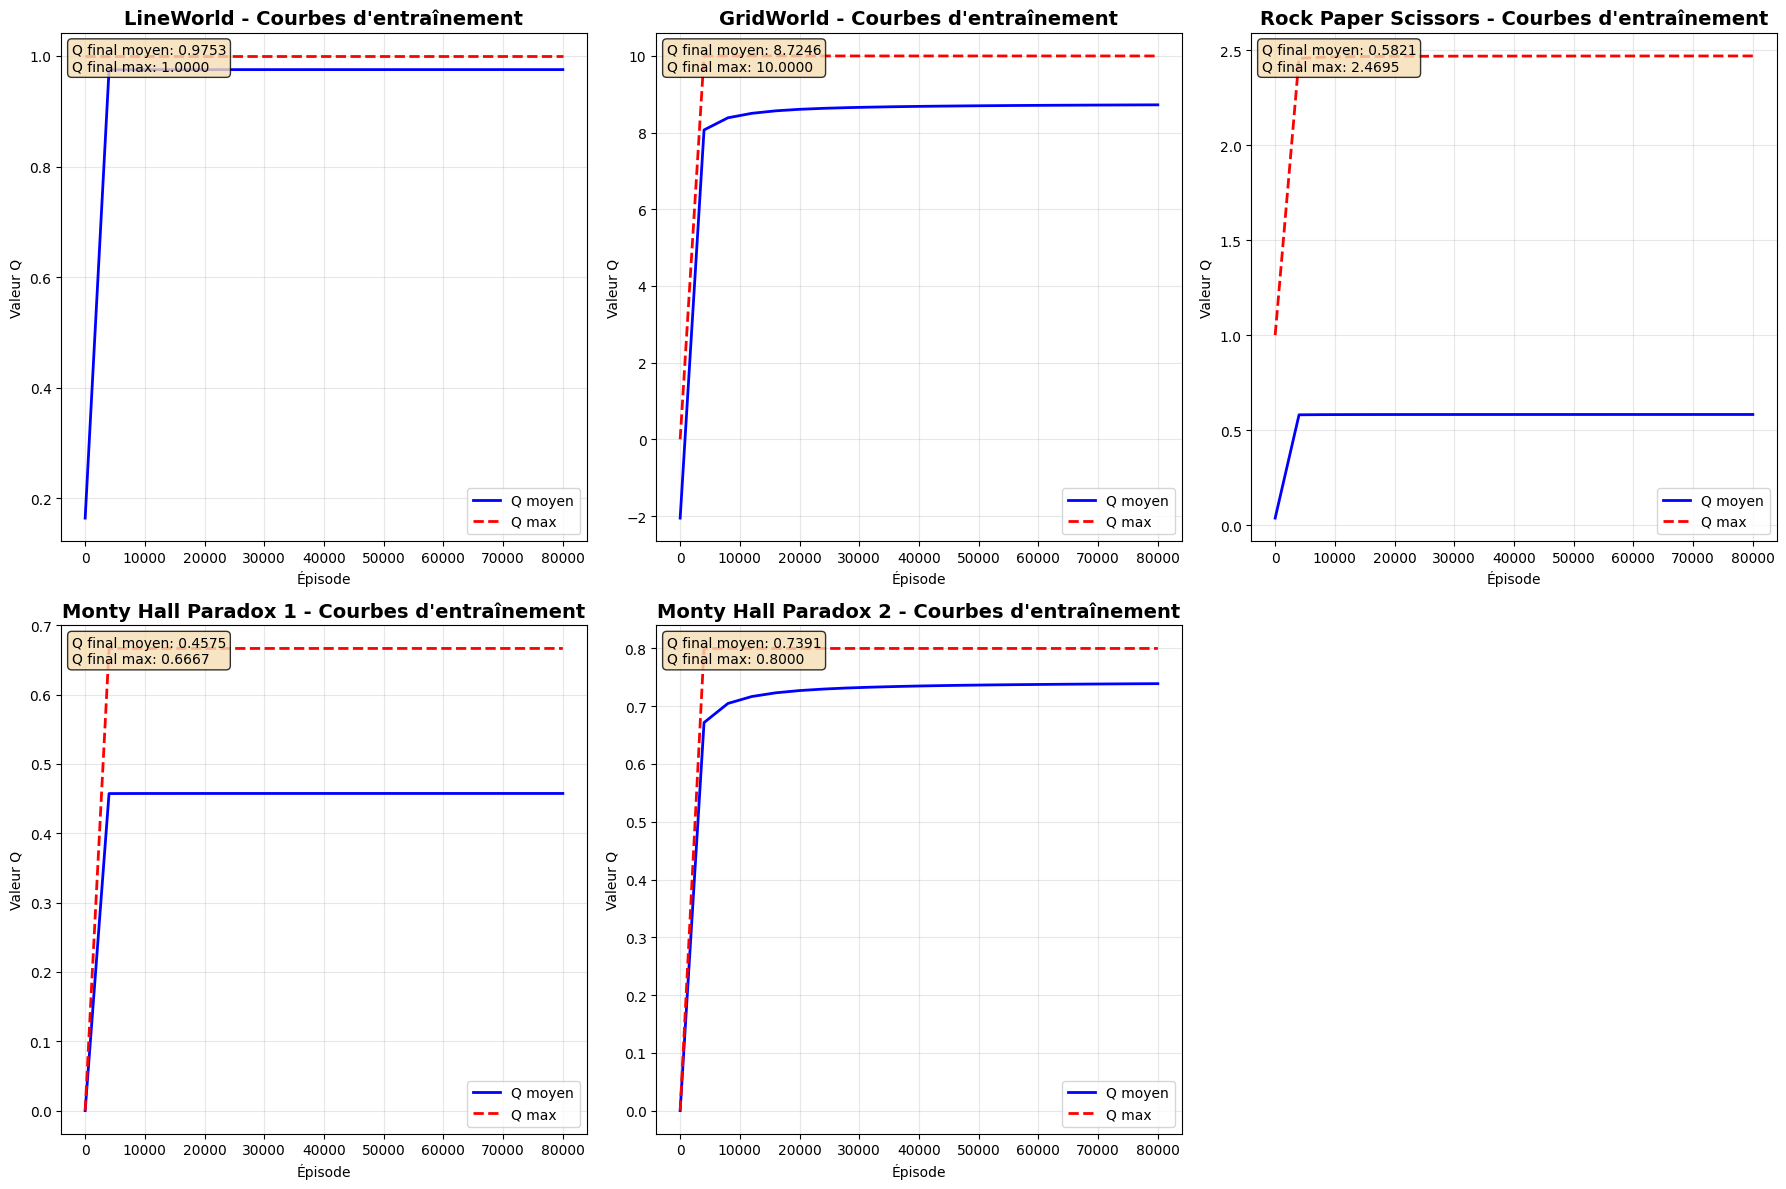

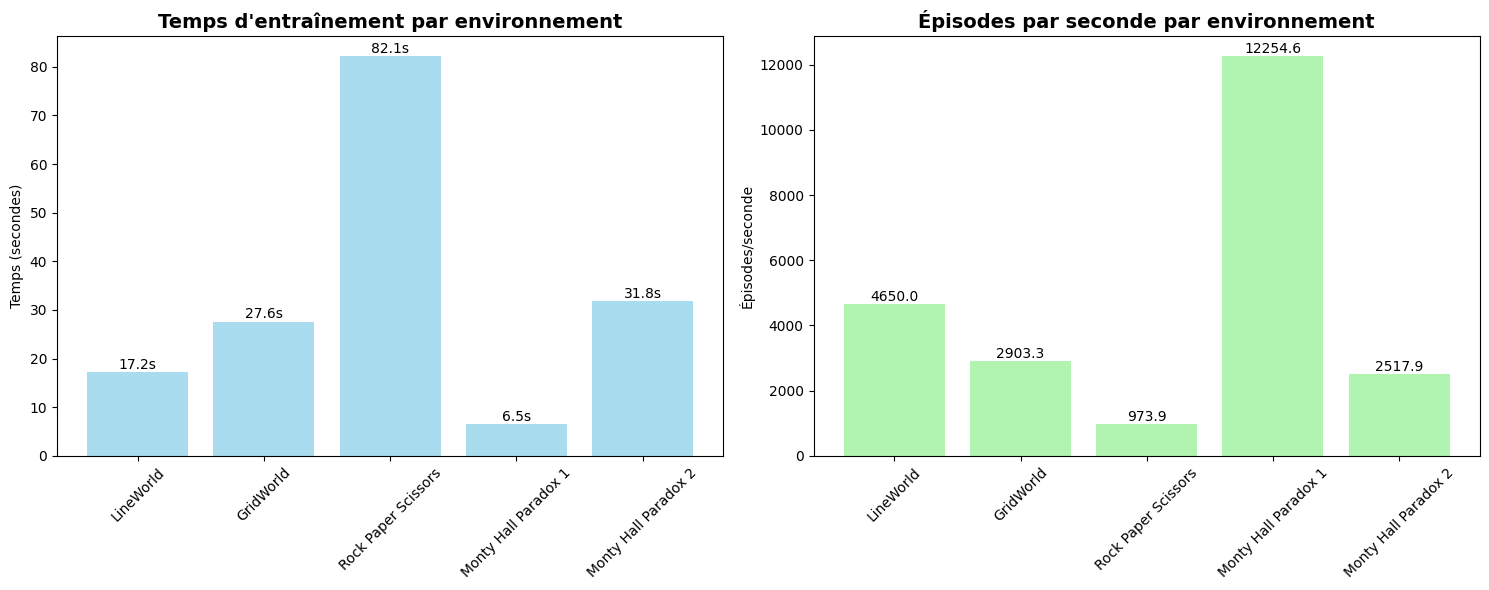

In [ ]:
# Visualisation des résultats
plot_training_curves(all_results)

In [ ]:
# Analyse détaillée des politiques apprises
print("ANALYSE DÉTAILLÉE DES POLITIQUES APPRISES")
print("="*80)

for env_name, result in all_results.items():
    if result:
        print(f"\n{result['env_name']}:")
        print(f"  Politique finale: {result['policy']}")
        print(f"  Q-table shape: {result['Q'].shape}")
        print(f"  Q-table non-nuls: {np.count_nonzero(result['Q'])}/{result['Q'].size}")
        
        # Afficher les meilleures actions par état
        best_actions = np.argmax(result['Q'], axis=1)
        print(f"  Meilleures actions par état: {best_actions}")
        
        # Statistiques sur les récompenses
        if 'history' in result and result['history']:
            final_episode_length = result['history'][-1]['episode_length']
            print(f"  Longueur moyenne d'épisode: {final_episode_length}")

ANALYSE DÉTAILLÉE DES POLITIQUES APPRISES

LineWorld:
  Politique finale: [0 0 0 0 0 0 1 1 1 1 1 0]
  Q-table shape: (12, 2)
  Q-table non-nuls: 24/24
  Meilleures actions par état: [0 0 0 0 0 0 1 1 1 1 1 1]
  Longueur moyenne d'épisode: 6

GridWorld:
  Politique finale: [0 0 0 0 0 0 2 2 2 2 2 3 2 2 2 2 1 3 2 2 3 3 3 3 2 1 3 3 1 3 1 1 1 1 1 0]
  Q-table shape: (36, 4)
  Q-table non-nuls: 136/144
  Meilleures actions par état: [0 0 0 0 0 0 2 2 2 2 2 3 2 2 2 2 1 3 2 2 3 3 3 3 2 1 3 3 1 3 1 1 1 1 1 0]
  Longueur moyenne d'épisode: 6

Rock Paper Scissors:
  Politique finale: [0 1 2 0 1 2 0 0 0]
  Q-table shape: (9, 3)
  Q-table non-nuls: 18/27
  Meilleures actions par état: [0 1 2 0 1 2 0 0 0]
  Longueur moyenne d'épisode: 1

Monty Hall Paradox 1:
  Politique finale: [1 1 1 1 1 1 1 0]
  Q-table shape: (8, 2)
  Q-table non-nuls: 14/16
  Meilleures actions par état: [1 1 1 1 1 1 1 0]
  Longueur moyenne d'épisode: 1

Monty Hall Paradox 2:
  Politique finale: [3 2 4 2 3 4 3 2 2 1 3 1 3 1 2 4 2

In [ ]:
# Sauvegarde des résultats
import pickle
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"monte_carlo_aggressive_results_{timestamp}.pkl"

# Préparer les données pour la sauvegarde (enlever les objets non-sérialisables)
save_data = {}
for env_name, result in all_results.items():
    if result:
        save_data[env_name] = {
            'Q': result['Q'],
            'policy': result['policy'],
            'returns_count': result['returns_count'],
            'env_name': result['env_name'],
            'training_time': result['training_time'],
            'config': result['config']
        }
        if 'history' in result:
            save_data[env_name]['history'] = result['history']

with open(filename, 'wb') as f:
    pickle.dump(save_data, f)

print(f"Résultats sauvegardés dans: {filename}")
print("\nTous les tests Monte Carlo ES agressifs sont terminés !")

Résultats sauvegardés dans: monte_carlo_aggressive_results_20250720_183835.pkl

Tous les tests Monte Carlo ES agressifs sont terminés !
